# Time Series Forecasting System
Time Series is a big component of our everyday lives. They are in fact used in medicine (EEG analysis), finance (Stock Prices) and electronics (Sensor Data Analysis). Many Machine Learning models have been created in order to tackle these types of tasks, two examples are ARIMA (AutoRegressive Integrated Moving Average) models and RNNs (Recurrent Neural Networks).


# Data Source

For Time series analysis, we are going to deal with Stock market Analysis. This dataset is based US-based stocks daily price and volume data.
Dataset taken for analysis is IBM stock market data from 2006-01-01 to 2018-01-01.

Below are the key fields in the dataset:

__`Date, Open, High, Low, Close, Volume, Name`__

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
print(df.shape)
print(df.columns)

(3020, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [4]:
# Cleaning up the data
df.isnull().values.any()
df = df.dropna()
df.shape

(3019, 7)

In [5]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.We will just examine the “Open” stock prices feature. This same analysis can be repeated for most of the other features.

# Visualization

### Visualizing the High and Low prices of IBM

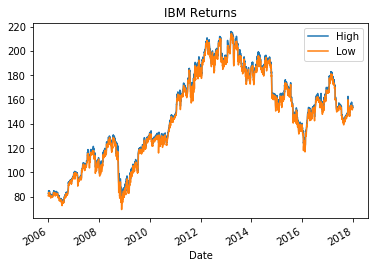

In [6]:
dr = df[['High', 'Low']]
dr.plot()
plt.title('IBM Returns');

### Q1: Visualize the Open and Close prices of IBM

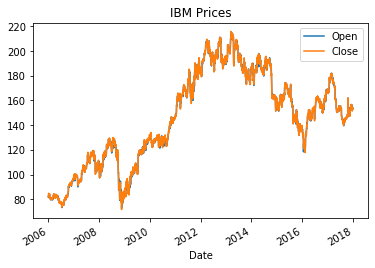

In [7]:
dr = df[['Open', 'Close']]
dr.plot()
plt.title('IBM Prices');

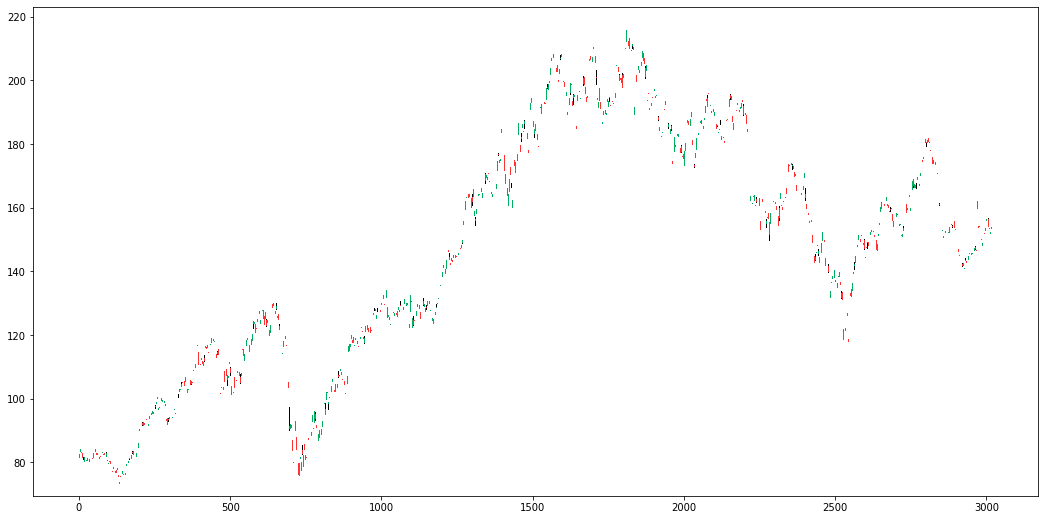

In [8]:
def plotdate_candlestick(p, alpha = 1.0):
    plt.figure(figsize = [18, 9])
    ti = np.arange(len(p))
    # Date, Open, High, Low, Close, Close_adjusted, volume
    #    0,    1,    2,   3,     4,             5,       6    
    # wicks
    plt.bar(ti, p['High'] - p['Low'], width = 0.10, bottom = p['Low'],color = [0,0,0], alpha = alpha)
    
    # Candle body
    top = np.max(np.column_stack((p['Open'], p['Close'])),axis=1)
    bot = np.min(np.column_stack((p['Open'], p['Close'])),axis=1)
    rgb = np.column_stack((np.ones(len(p))*255, np.ones(len(p))*50, np.ones(len(p))*50)) # matrix red
    rgb[p['Close'].values>p['Open'].values,:] = [0, 175, 95] 
    plt.bar(ti, top - bot, width = 0.8, bottom = bot, color = rgb/255, alpha = alpha)
    
    '''
    #plt.xticks(np.arange(0, ti[0], 5))
    ax = plt.gca()
    xticks = np.arange(0,len(p),5)
    xticklabels = p[np.arange(0,len(p),5),0]
    for xt, xticklabel in enumerate(xticklabels):
        xticklabels[xt] = pd.to_datetime(xticklabel).strftime('%m\%d\%y')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(8)     
        #tick.label.set_rotation(45)
    
    return ax, rgb
    '''

plotdate_candlestick(df, alpha = 1.0)

### Q2: Visualize the Open and Close Cumulative Prices of IBM

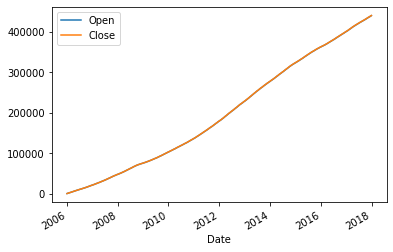

In [9]:
dr_cumsum = dr.cumsum()
dr_cumsum.plot()

####  Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

### Auto-correlation plot with Lag 1

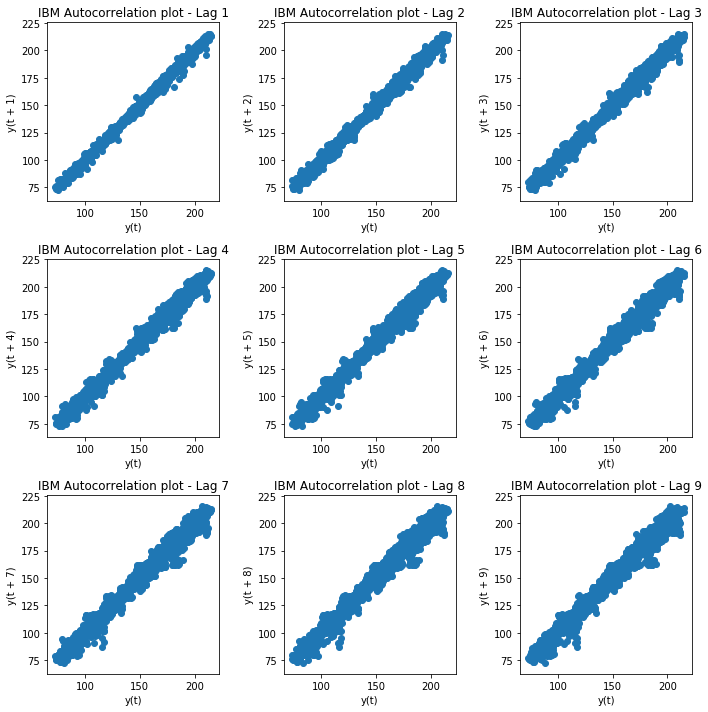

In [10]:
# START_CODE_HERE - plot the Autocorrelation plot for feature 'Open'
from pandas.plotting import lag_plot
import numpy as np

plt.figure(figsize=(10,10))

for i in np.arange(1,10):
    plt.subplot(3,3,i)
    lag_plot(df['Open'], lag=i)
    plt.title('IBM Autocorrelation plot - Lag %i'%i);
    plt.axis('equal')

plt.tight_layout()
# END_CODE_HERE

### Q3: Visualize the Auto-Correlation plot for IBM Open prices with Lag 5 

(65.59814336917563, 222.52185663082435, 65.5928233995585, 222.5271766004415)

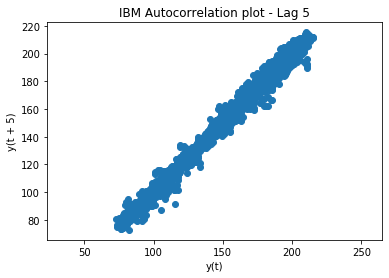

In [11]:
lag_plot(df['Open'], lag=5)
plt.title('IBM Autocorrelation plot - Lag %i'%5);
plt.axis('equal')

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

## Build Train-Test Datasets

#### Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [12]:
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]

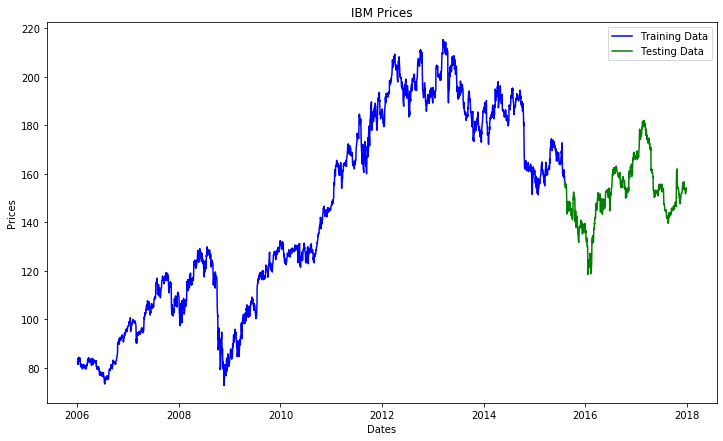

In [13]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

# ARIMA (AutoRegressive Integrated Moving Average)

The acronym of ARIMA stands for:

AutoRegressive(AR) = the model takes advantage of the connection between a predefined number of lagged observations and the current one.

Integrated(I) = differencing between raw observations (eg. subtracting observations at different time steps).

Moving Average(MA) = the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q). These are:

p = number of lag observations.

d = the degree of differencing.

q = the size of the moving average window.



## Understaning the ARIMA Model

### the ARIMA parameters - used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q. You have already learnt a fair bit of this in the curriculum but following is a brief refresher.

__p:__ is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

__d:__ is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

__q:__ is the parameter associated with the moving average part of the model.

### Approach to determine the parameters
There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

Another approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.


In this exercise, we will look into the statistical method of getting these values from auto-correlation and correlation plots.

### Stationarity of the data - Determine the d value

Stationarity typically indicates various statistical measures of the time series do not change over time. Thus, a time series is stationary when its mean, variance and auto-correlation, etc., are constant over time. 

Most time-series forecasting models typically perform well when the series is stationary and hence it is important to find out if your time-series dataset is stationary. 

ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. 

Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. 

If the plot does not appear relatively stationary, your model will likely need a differencing term. 

The Augmented Dickey-Fuller test is an important statistical test which we will use to prove if the series is stationary or not and take necessary steps in case it is not stationary.

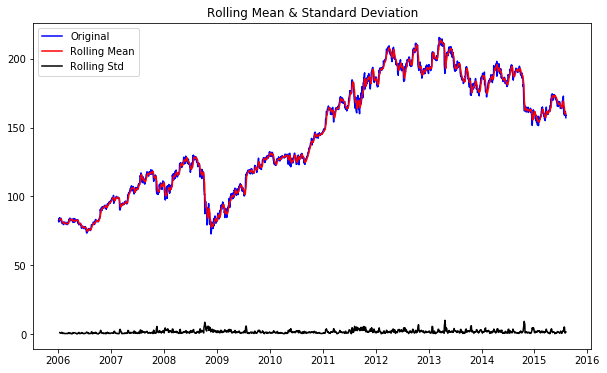

In [14]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean() # 7 day moving average
rolstd = train_series.rolling(window).std() # 7 day standard deviation

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');


In [15]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. F

rom the above statistics, we can observe that the p-value is 0.539 which proves that our series is not stationary.

To get stationary data, there are many techniques. We can use log, differencing and so on. Let's use a first order differencing here.

### Q4: Apply a first order differencing on the training data

Hint: Check out the __`diff()`__ function in pandas and try using it on the __`train_series`__ dataset

In [16]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
print(train_diff)

Date
2006-01-04   -0.25
2006-01-05   -0.80
2006-01-06    2.55
2006-01-09    0.15
2006-01-10   -0.95
              ... 
2015-07-31    0.90
2015-08-03    0.30
2015-08-04   -3.30
2015-08-05    0.70
2015-08-06   -1.97
Name: Open, Length: 2414, dtype: float64


### Q5: Visualize Rolling statistics for differenced train data

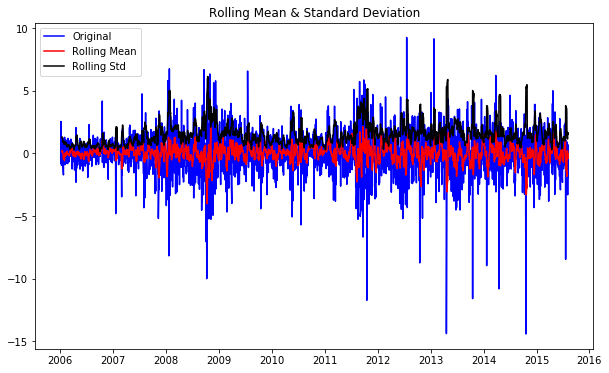

In [17]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_diff.rolling(window).mean() # 7 day moving average
rolstd = train_diff.rolling(window).std() # 7 day standard deviation

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

### Q6: Compute AD-Fuller Stats for differenced train data

In [18]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

print(dftest[1])

Test Statistic                  -20.324277
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64
0.0


After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### ACF Plots (Auto Correlation Function):
ACF is an auto-correlation function which gives us correlation of any series with its lagged values(previous timestep values).

ACF plot describes the correlation of the current value with the previous lagged values(specified by *lags*).

For example, how the dependency chain is followed as direct dependency .... $S_{t-2} --> S_{t-1} --> S_t$*

Also, ACF finds correlation between $S_{t-2} --> S_t$ (indirect dependency).

* --> = represents dependency

#### Limitation: 
ACF is not very accurate as indirect dependency is affected by direct dependency and so the plots are always above the confidence band(as shown below).

### PACF Plots: Pearson Auto Correlation Function:
PACF plots models the indirect dependencies and is not affected by the direct dependencies.

$S_{t-2} --> S_t$

From the below example we can see how today's value is affected by the last 10 days. 

The points that lie inside the blue confidence band do not correlate with or affect today's value. In ACF, we saw that all values are above the confidence band(as $S_{t-2} --> S{t}$ is affected by $S_{t-1} --> S_t$), which is not a good representation of the correlation.


In PACF, indirect dependencies are modelled well.

## ACF and PACF - AR and MA Intuition
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Plot ACF and PACF on the original train series

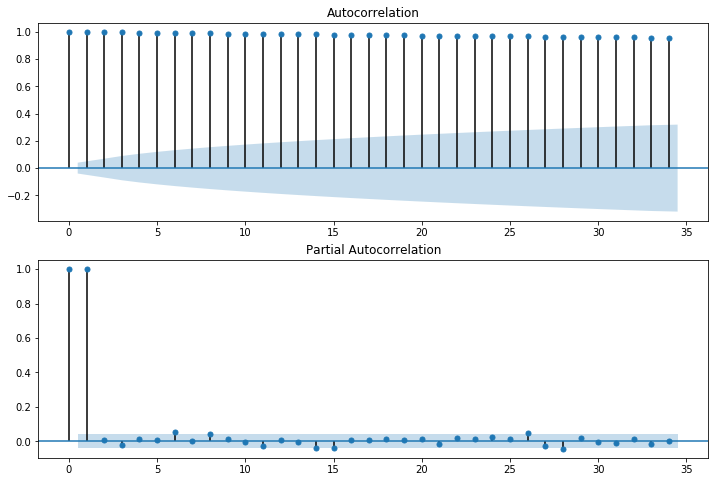

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

### Q7: Plot ACF and PACF on the differenced train series

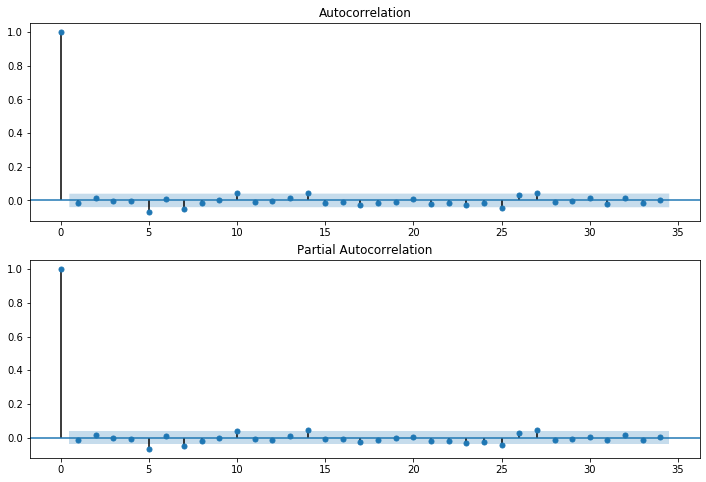

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# How to determine p, d, q

It's easy to determine d. In our case, we see the first order differencing make the ts stationary. Hence d = 1

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 5 lags the AR is significant. Which means, we can use AR = 5 i.e, p = 5

To avoid the potential for incorrectly specifying the MA order to be too high we set MA = 0 i.e q = 0 by taking a look at the ACF plot though we do have a value of 5 which is significant considering the interval but we start off with the first lag value i.e q = 0.

Hence:

- p=5
- d=1
- q=0

# Evaluation of ARIMA Model

In order to evaluate the ARIMA model,we can use two different error functions:

- Mean Squared Error (MSE)
- Symmetric Mean Absolute Percentage Error (SMAPE)

SMAPE is commonly used as an accuracy measure based on relative errors

### SMAPE

![](imgs/smape.png)

SMAPE is not currently supported in Scikit-learn as a loss function, therefore we first create this function.

In [21]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

### Q8: Difference the Test Series

In [22]:
test_series = test_data['Open']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)

In [23]:
print(train_diff)
print(test_diff)

Date
2006-01-04   -0.25
2006-01-05   -0.80
2006-01-06    2.55
2006-01-09    0.15
2006-01-10   -0.95
              ... 
2015-07-31    0.90
2015-08-03    0.30
2015-08-04   -3.30
2015-08-05    0.70
2015-08-06   -1.97
Name: Open, Length: 2414, dtype: float64
Date
2015-08-10    0.88
2015-08-11   -0.81
2015-08-12   -1.70
2015-08-13    1.80
2015-08-14   -1.06
              ... 
2017-12-22   -1.35
2017-12-26    0.69
2017-12-27    0.44
2017-12-28    0.25
2017-12-29    0.97
Name: Open, Length: 603, dtype: float64


### Q9: Train and Forecast using ARIMA Model by filling in the necessary blocks

Note: Here we will use a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model.
Of course this is not the only way for forecasting and you can do it in multiple ways e.g just use train data to forecast, use a window of days to forecast including test data and so on.

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [25]:
train_set = train_diff.append(test_diff[0:2])
print(train_set)

Date
2006-01-04   -0.25
2006-01-05   -0.80
2006-01-06    2.55
2006-01-09    0.15
2006-01-10   -0.95
              ... 
2015-08-04   -3.30
2015-08-05    0.70
2015-08-06   -1.97
2015-08-10    0.88
2015-08-11   -0.81
Name: Open, Length: 2416, dtype: float64


In [31]:
import warnings
import itertools
warnings.filterwarnings('ignore')

def arima_gridsearch(p,d):
    predictions = []
    for t in range(len(test_diff)):
        print('Predicting %i of %i'%(t+1, len(test_diff)))
        train_set = train_diff.append(test_diff[:t+1])
        model = ARIMA(train_set.values, order = [p, d, 0]) # initialize the model with history and right order of parameters
        model_fit = model.fit()# fit the model
        output = model_fit.forecast(steps=1)  # use forecast on the fitted model

        yhat = output[0][0]
        predictions.append(yhat)

        if t % 20 == 0:
          print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))
    reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
    return reverse_predictions

params = []
results = []
for p, d in itertools.product([5, 7, 10], [0, 1, 2]):
    params.append([p,d])
    reverse_predictions = arima_gridsearch(p,d)
    results.append(reverse_predictions)

Predicting 1 of 603
Test Series Point: 0	Predicted=-0.006766789644008314, Expected=2.3600000000000136
Predicting 2 of 603
Predicting 3 of 603
Predicting 4 of 603
Predicting 5 of 603
Predicting 6 of 603
Predicting 7 of 603
Predicting 8 of 603
Predicting 9 of 603
Predicting 10 of 603
Predicting 11 of 603
Predicting 12 of 603
Predicting 13 of 603
Predicting 14 of 603
Predicting 15 of 603
Predicting 16 of 603
Predicting 17 of 603
Predicting 18 of 603
Predicting 19 of 603
Predicting 20 of 603
Predicting 21 of 603
Test Series Point: 20	Predicted=0.12751784920942544, Expected=2.3600000000000136
Predicting 22 of 603
Predicting 23 of 603
Predicting 24 of 603
Predicting 25 of 603
Predicting 26 of 603
Predicting 27 of 603
Predicting 28 of 603
Predicting 29 of 603
Predicting 30 of 603
Predicting 31 of 603
Predicting 32 of 603
Predicting 33 of 603
Predicting 34 of 603
Predicting 35 of 603
Predicting 36 of 603
Predicting 37 of 603
Predicting 38 of 603
Predicting 39 of 603
Predicting 40 of 603
Predic

Predicting 319 of 603
Predicting 320 of 603
Predicting 321 of 603
Test Series Point: 320	Predicted=-0.005151491621312045, Expected=2.3600000000000136
Predicting 322 of 603
Predicting 323 of 603
Predicting 324 of 603
Predicting 325 of 603
Predicting 326 of 603
Predicting 327 of 603
Predicting 328 of 603
Predicting 329 of 603
Predicting 330 of 603
Predicting 331 of 603
Predicting 332 of 603
Predicting 333 of 603
Predicting 334 of 603
Predicting 335 of 603
Predicting 336 of 603
Predicting 337 of 603
Predicting 338 of 603
Predicting 339 of 603
Predicting 340 of 603
Predicting 341 of 603
Test Series Point: 340	Predicted=-0.029411131630506814, Expected=2.3600000000000136
Predicting 342 of 603
Predicting 343 of 603
Predicting 344 of 603
Predicting 345 of 603
Predicting 346 of 603
Predicting 347 of 603
Predicting 348 of 603
Predicting 349 of 603
Predicting 350 of 603
Predicting 351 of 603
Predicting 352 of 603
Predicting 353 of 603
Predicting 354 of 603
Predicting 355 of 603
Predicting 356 of 

Predicting 27 of 603
Predicting 28 of 603
Predicting 29 of 603
Predicting 30 of 603
Predicting 31 of 603
Predicting 32 of 603
Predicting 33 of 603
Predicting 34 of 603
Predicting 35 of 603
Predicting 36 of 603
Predicting 37 of 603
Predicting 38 of 603
Predicting 39 of 603
Predicting 40 of 603
Predicting 41 of 603
Test Series Point: 40	Predicted=0.7005342780245636, Expected=2.3600000000000136
Predicting 42 of 603
Predicting 43 of 603
Predicting 44 of 603
Predicting 45 of 603
Predicting 46 of 603
Predicting 47 of 603
Predicting 48 of 603
Predicting 49 of 603
Predicting 50 of 603
Predicting 51 of 603
Predicting 52 of 603
Predicting 53 of 603
Predicting 54 of 603
Predicting 55 of 603
Predicting 56 of 603
Predicting 57 of 603
Predicting 58 of 603
Predicting 59 of 603
Predicting 60 of 603
Predicting 61 of 603
Test Series Point: 60	Predicted=-0.5126760292698812, Expected=2.3600000000000136
Predicting 62 of 603
Predicting 63 of 603
Predicting 64 of 603
Predicting 65 of 603
Predicting 66 of 603

Predicting 344 of 603
Predicting 345 of 603
Predicting 346 of 603
Predicting 347 of 603
Predicting 348 of 603
Predicting 349 of 603
Predicting 350 of 603
Predicting 351 of 603
Predicting 352 of 603
Predicting 353 of 603
Predicting 354 of 603
Predicting 355 of 603
Predicting 356 of 603
Predicting 357 of 603
Predicting 358 of 603
Predicting 359 of 603
Predicting 360 of 603
Predicting 361 of 603
Test Series Point: 360	Predicted=0.05510764591825268, Expected=2.3600000000000136
Predicting 362 of 603
Predicting 363 of 603
Predicting 364 of 603
Predicting 365 of 603
Predicting 366 of 603
Predicting 367 of 603
Predicting 368 of 603
Predicting 369 of 603
Predicting 370 of 603
Predicting 371 of 603
Predicting 372 of 603
Predicting 373 of 603
Predicting 374 of 603
Predicting 375 of 603
Predicting 376 of 603
Predicting 377 of 603
Predicting 378 of 603
Predicting 379 of 603
Predicting 380 of 603
Predicting 381 of 603
Test Series Point: 380	Predicted=0.5099234563547819, Expected=2.3600000000000136
P

Predicting 57 of 603
Predicting 58 of 603
Predicting 59 of 603
Predicting 60 of 603
Predicting 61 of 603
Test Series Point: 60	Predicted=0.48195364319072675, Expected=2.3600000000000136
Predicting 62 of 603
Predicting 63 of 603
Predicting 64 of 603
Predicting 65 of 603
Predicting 66 of 603
Predicting 67 of 603
Predicting 68 of 603
Predicting 69 of 603
Predicting 70 of 603
Predicting 71 of 603
Predicting 72 of 603
Predicting 73 of 603
Predicting 74 of 603
Predicting 75 of 603
Predicting 76 of 603
Predicting 77 of 603
Predicting 78 of 603
Predicting 79 of 603
Predicting 80 of 603
Predicting 81 of 603
Test Series Point: 80	Predicted=0.988966860630284, Expected=2.3600000000000136
Predicting 82 of 603
Predicting 83 of 603
Predicting 84 of 603
Predicting 85 of 603
Predicting 86 of 603
Predicting 87 of 603
Predicting 88 of 603
Predicting 89 of 603
Predicting 90 of 603
Predicting 91 of 603
Predicting 92 of 603
Predicting 93 of 603
Predicting 94 of 603
Predicting 95 of 603
Predicting 96 of 603


Predicting 373 of 603
Predicting 374 of 603
Predicting 375 of 603
Predicting 376 of 603
Predicting 377 of 603
Predicting 378 of 603
Predicting 379 of 603
Predicting 380 of 603
Predicting 381 of 603
Test Series Point: 380	Predicted=0.7861177813870657, Expected=2.3600000000000136
Predicting 382 of 603
Predicting 383 of 603
Predicting 384 of 603
Predicting 385 of 603
Predicting 386 of 603
Predicting 387 of 603
Predicting 388 of 603
Predicting 389 of 603
Predicting 390 of 603
Predicting 391 of 603
Predicting 392 of 603
Predicting 393 of 603
Predicting 394 of 603
Predicting 395 of 603
Predicting 396 of 603
Predicting 397 of 603
Predicting 398 of 603
Predicting 399 of 603
Predicting 400 of 603
Predicting 401 of 603
Test Series Point: 400	Predicted=-0.5366953296521476, Expected=2.3600000000000136
Predicting 402 of 603
Predicting 403 of 603
Predicting 404 of 603
Predicting 405 of 603
Predicting 406 of 603
Predicting 407 of 603
Predicting 408 of 603
Predicting 409 of 603
Predicting 410 of 603
P

Predicting 84 of 603
Predicting 85 of 603
Predicting 86 of 603
Predicting 87 of 603
Predicting 88 of 603
Predicting 89 of 603
Predicting 90 of 603
Predicting 91 of 603
Predicting 92 of 603
Predicting 93 of 603
Predicting 94 of 603
Predicting 95 of 603
Predicting 96 of 603
Predicting 97 of 603
Predicting 98 of 603
Predicting 99 of 603
Predicting 100 of 603
Predicting 101 of 603
Test Series Point: 100	Predicted=0.0686990144121342, Expected=2.3600000000000136
Predicting 102 of 603
Predicting 103 of 603
Predicting 104 of 603
Predicting 105 of 603
Predicting 106 of 603
Predicting 107 of 603
Predicting 108 of 603
Predicting 109 of 603
Predicting 110 of 603
Predicting 111 of 603
Predicting 112 of 603
Predicting 113 of 603
Predicting 114 of 603
Predicting 115 of 603
Predicting 116 of 603
Predicting 117 of 603
Predicting 118 of 603
Predicting 119 of 603
Predicting 120 of 603
Predicting 121 of 603
Test Series Point: 120	Predicted=-0.2182723573907208, Expected=2.3600000000000136
Predicting 122 of

Predicting 401 of 603
Test Series Point: 400	Predicted=0.05852869660613892, Expected=2.3600000000000136
Predicting 402 of 603
Predicting 403 of 603
Predicting 404 of 603
Predicting 405 of 603
Predicting 406 of 603
Predicting 407 of 603
Predicting 408 of 603
Predicting 409 of 603
Predicting 410 of 603
Predicting 411 of 603
Predicting 412 of 603
Predicting 413 of 603
Predicting 414 of 603
Predicting 415 of 603
Predicting 416 of 603
Predicting 417 of 603
Predicting 418 of 603
Predicting 419 of 603
Predicting 420 of 603
Predicting 421 of 603
Test Series Point: 420	Predicted=0.021410194512157782, Expected=2.3600000000000136
Predicting 422 of 603
Predicting 423 of 603
Predicting 424 of 603
Predicting 425 of 603
Predicting 426 of 603
Predicting 427 of 603
Predicting 428 of 603
Predicting 429 of 603
Predicting 430 of 603
Predicting 431 of 603
Predicting 432 of 603
Predicting 433 of 603
Predicting 434 of 603
Predicting 435 of 603
Predicting 436 of 603
Predicting 437 of 603
Predicting 438 of 603

Predicting 113 of 603
Predicting 114 of 603
Predicting 115 of 603
Predicting 116 of 603
Predicting 117 of 603
Predicting 118 of 603
Predicting 119 of 603
Predicting 120 of 603
Predicting 121 of 603
Test Series Point: 120	Predicted=0.5606602417851173, Expected=2.3600000000000136
Predicting 122 of 603
Predicting 123 of 603
Predicting 124 of 603
Predicting 125 of 603
Predicting 126 of 603
Predicting 127 of 603
Predicting 128 of 603
Predicting 129 of 603
Predicting 130 of 603
Predicting 131 of 603
Predicting 132 of 603
Predicting 133 of 603
Predicting 134 of 603
Predicting 135 of 603
Predicting 136 of 603
Predicting 137 of 603
Predicting 138 of 603
Predicting 139 of 603
Predicting 140 of 603
Predicting 141 of 603
Test Series Point: 140	Predicted=0.26206714386525914, Expected=2.3600000000000136
Predicting 142 of 603
Predicting 143 of 603
Predicting 144 of 603
Predicting 145 of 603
Predicting 146 of 603
Predicting 147 of 603
Predicting 148 of 603
Predicting 149 of 603
Predicting 150 of 603
P

Predicting 426 of 603
Predicting 427 of 603
Predicting 428 of 603
Predicting 429 of 603
Predicting 430 of 603
Predicting 431 of 603
Predicting 432 of 603
Predicting 433 of 603
Predicting 434 of 603
Predicting 435 of 603
Predicting 436 of 603
Predicting 437 of 603
Predicting 438 of 603
Predicting 439 of 603
Predicting 440 of 603
Predicting 441 of 603
Test Series Point: 440	Predicted=-1.0325387695216641, Expected=2.3600000000000136
Predicting 442 of 603
Predicting 443 of 603
Predicting 444 of 603
Predicting 445 of 603
Predicting 446 of 603
Predicting 447 of 603
Predicting 448 of 603
Predicting 449 of 603
Predicting 450 of 603
Predicting 451 of 603
Predicting 452 of 603
Predicting 453 of 603
Predicting 454 of 603
Predicting 455 of 603
Predicting 456 of 603
Predicting 457 of 603
Predicting 458 of 603
Predicting 459 of 603
Predicting 460 of 603
Predicting 461 of 603
Test Series Point: 460	Predicted=-0.05298776158872376, Expected=2.3600000000000136
Predicting 462 of 603
Predicting 463 of 603

Predicting 141 of 603
Test Series Point: 140	Predicted=-2.0604169031197914, Expected=2.3600000000000136
Predicting 142 of 603
Predicting 143 of 603
Predicting 144 of 603
Predicting 145 of 603
Predicting 146 of 603
Predicting 147 of 603
Predicting 148 of 603
Predicting 149 of 603
Predicting 150 of 603
Predicting 151 of 603
Predicting 152 of 603
Predicting 153 of 603
Predicting 154 of 603
Predicting 155 of 603
Predicting 156 of 603
Predicting 157 of 603
Predicting 158 of 603
Predicting 159 of 603
Predicting 160 of 603
Predicting 161 of 603
Test Series Point: 160	Predicted=0.5234519855303104, Expected=2.3600000000000136
Predicting 162 of 603
Predicting 163 of 603
Predicting 164 of 603
Predicting 165 of 603
Predicting 166 of 603
Predicting 167 of 603
Predicting 168 of 603
Predicting 169 of 603
Predicting 170 of 603
Predicting 171 of 603
Predicting 172 of 603
Predicting 173 of 603
Predicting 174 of 603
Predicting 175 of 603
Predicting 176 of 603
Predicting 177 of 603
Predicting 178 of 603
P

Predicting 455 of 603
Predicting 456 of 603
Predicting 457 of 603
Predicting 458 of 603
Predicting 459 of 603
Predicting 460 of 603
Predicting 461 of 603
Test Series Point: 460	Predicted=0.1991440773088855, Expected=2.3600000000000136
Predicting 462 of 603
Predicting 463 of 603
Predicting 464 of 603
Predicting 465 of 603
Predicting 466 of 603
Predicting 467 of 603
Predicting 468 of 603
Predicting 469 of 603
Predicting 470 of 603
Predicting 471 of 603
Predicting 472 of 603
Predicting 473 of 603
Predicting 474 of 603
Predicting 475 of 603
Predicting 476 of 603
Predicting 477 of 603
Predicting 478 of 603
Predicting 479 of 603
Predicting 480 of 603
Predicting 481 of 603
Test Series Point: 480	Predicted=-0.644054938980231, Expected=2.3600000000000136
Predicting 482 of 603
Predicting 483 of 603
Predicting 484 of 603
Predicting 485 of 603
Predicting 486 of 603
Predicting 487 of 603
Predicting 488 of 603
Predicting 489 of 603
Predicting 490 of 603
Predicting 491 of 603
Predicting 492 of 603
Pr

Predicting 167 of 603
Predicting 168 of 603
Predicting 169 of 603
Predicting 170 of 603
Predicting 171 of 603
Predicting 172 of 603
Predicting 173 of 603
Predicting 174 of 603
Predicting 175 of 603
Predicting 176 of 603
Predicting 177 of 603
Predicting 178 of 603
Predicting 179 of 603
Predicting 180 of 603
Predicting 181 of 603
Test Series Point: 180	Predicted=0.07669205244162844, Expected=2.3600000000000136
Predicting 182 of 603
Predicting 183 of 603
Predicting 184 of 603
Predicting 185 of 603
Predicting 186 of 603
Predicting 187 of 603
Predicting 188 of 603
Predicting 189 of 603
Predicting 190 of 603
Predicting 191 of 603
Predicting 192 of 603
Predicting 193 of 603
Predicting 194 of 603
Predicting 195 of 603
Predicting 196 of 603
Predicting 197 of 603
Predicting 198 of 603
Predicting 199 of 603
Predicting 200 of 603
Predicting 201 of 603
Test Series Point: 200	Predicted=-0.011481379194510206, Expected=2.3600000000000136
Predicting 202 of 603
Predicting 203 of 603
Predicting 204 of 60

Predicting 483 of 603
Predicting 484 of 603
Predicting 485 of 603
Predicting 486 of 603
Predicting 487 of 603
Predicting 488 of 603
Predicting 489 of 603
Predicting 490 of 603
Predicting 491 of 603
Predicting 492 of 603
Predicting 493 of 603
Predicting 494 of 603
Predicting 495 of 603
Predicting 496 of 603
Predicting 497 of 603
Predicting 498 of 603
Predicting 499 of 603
Predicting 500 of 603
Predicting 501 of 603
Test Series Point: 500	Predicted=0.017785100623298085, Expected=2.3600000000000136
Predicting 502 of 603
Predicting 503 of 603
Predicting 504 of 603
Predicting 505 of 603
Predicting 506 of 603
Predicting 507 of 603
Predicting 508 of 603
Predicting 509 of 603
Predicting 510 of 603
Predicting 511 of 603
Predicting 512 of 603
Predicting 513 of 603
Predicting 514 of 603
Predicting 515 of 603
Predicting 516 of 603
Predicting 517 of 603
Predicting 518 of 603
Predicting 519 of 603
Predicting 520 of 603
Predicting 521 of 603
Test Series Point: 520	Predicted=-0.10950871944069648, Expe

Predicting 198 of 603
Predicting 199 of 603
Predicting 200 of 603
Predicting 201 of 603
Test Series Point: 200	Predicted=-0.004995239783792016, Expected=2.3600000000000136
Predicting 202 of 603
Predicting 203 of 603
Predicting 204 of 603
Predicting 205 of 603
Predicting 206 of 603
Predicting 207 of 603
Predicting 208 of 603
Predicting 209 of 603
Predicting 210 of 603
Predicting 211 of 603
Predicting 212 of 603
Predicting 213 of 603
Predicting 214 of 603
Predicting 215 of 603
Predicting 216 of 603
Predicting 217 of 603
Predicting 218 of 603
Predicting 219 of 603
Predicting 220 of 603
Predicting 221 of 603
Test Series Point: 220	Predicted=-0.11386823524473827, Expected=2.3600000000000136
Predicting 222 of 603
Predicting 223 of 603
Predicting 224 of 603
Predicting 225 of 603
Predicting 226 of 603
Predicting 227 of 603
Predicting 228 of 603
Predicting 229 of 603
Predicting 230 of 603
Predicting 231 of 603
Predicting 232 of 603
Predicting 233 of 603
Predicting 234 of 603
Predicting 235 of 6

Predicting 511 of 603
Predicting 512 of 603
Predicting 513 of 603
Predicting 514 of 603
Predicting 515 of 603
Predicting 516 of 603
Predicting 517 of 603
Predicting 518 of 603
Predicting 519 of 603
Predicting 520 of 603
Predicting 521 of 603
Test Series Point: 520	Predicted=-0.0734382965004902, Expected=2.3600000000000136
Predicting 522 of 603
Predicting 523 of 603
Predicting 524 of 603
Predicting 525 of 603
Predicting 526 of 603
Predicting 527 of 603
Predicting 528 of 603
Predicting 529 of 603
Predicting 530 of 603
Predicting 531 of 603
Predicting 532 of 603
Predicting 533 of 603
Predicting 534 of 603
Predicting 535 of 603
Predicting 536 of 603
Predicting 537 of 603
Predicting 538 of 603
Predicting 539 of 603
Predicting 540 of 603
Predicting 541 of 603
Test Series Point: 540	Predicted=-0.04340285544402136, Expected=2.3600000000000136
Predicting 542 of 603
Predicting 543 of 603
Predicting 544 of 603
Predicting 545 of 603
Predicting 546 of 603
Predicting 547 of 603
Predicting 548 of 603

Predicting 223 of 603
Predicting 224 of 603
Predicting 225 of 603
Predicting 226 of 603
Predicting 227 of 603
Predicting 228 of 603
Predicting 229 of 603
Predicting 230 of 603
Predicting 231 of 603
Predicting 232 of 603
Predicting 233 of 603
Predicting 234 of 603
Predicting 235 of 603
Predicting 236 of 603
Predicting 237 of 603
Predicting 238 of 603
Predicting 239 of 603
Predicting 240 of 603
Predicting 241 of 603
Test Series Point: 240	Predicted=0.07909109600518349, Expected=2.3600000000000136
Predicting 242 of 603
Predicting 243 of 603
Predicting 244 of 603
Predicting 245 of 603
Predicting 246 of 603
Predicting 247 of 603
Predicting 248 of 603
Predicting 249 of 603
Predicting 250 of 603
Predicting 251 of 603
Predicting 252 of 603
Predicting 253 of 603
Predicting 254 of 603
Predicting 255 of 603
Predicting 256 of 603
Predicting 257 of 603
Predicting 258 of 603
Predicting 259 of 603
Predicting 260 of 603
Predicting 261 of 603
Test Series Point: 260	Predicted=-0.5497735590162274, Expect

Predicting 540 of 603
Predicting 541 of 603
Test Series Point: 540	Predicted=-0.02267693071082999, Expected=2.3600000000000136
Predicting 542 of 603
Predicting 543 of 603
Predicting 544 of 603
Predicting 545 of 603
Predicting 546 of 603
Predicting 547 of 603
Predicting 548 of 603
Predicting 549 of 603
Predicting 550 of 603
Predicting 551 of 603
Predicting 552 of 603
Predicting 553 of 603
Predicting 554 of 603
Predicting 555 of 603
Predicting 556 of 603
Predicting 557 of 603
Predicting 558 of 603
Predicting 559 of 603
Predicting 560 of 603
Predicting 561 of 603
Test Series Point: 560	Predicted=-1.2040557111465537, Expected=2.3600000000000136
Predicting 562 of 603
Predicting 563 of 603
Predicting 564 of 603
Predicting 565 of 603
Predicting 566 of 603
Predicting 567 of 603
Predicting 568 of 603
Predicting 569 of 603
Predicting 570 of 603
Predicting 571 of 603
Predicting 572 of 603
Predicting 573 of 603
Predicting 574 of 603
Predicting 575 of 603
Predicting 576 of 603
Predicting 577 of 603

In [32]:
for k, param in enumerate(params):
    print(k, param)

0 [5, 0]
1 [5, 1]
2 [5, 2]
3 [7, 0]
4 [7, 1]
5 [7, 2]
6 [10, 0]
7 [10, 1]
8 [10, 2]


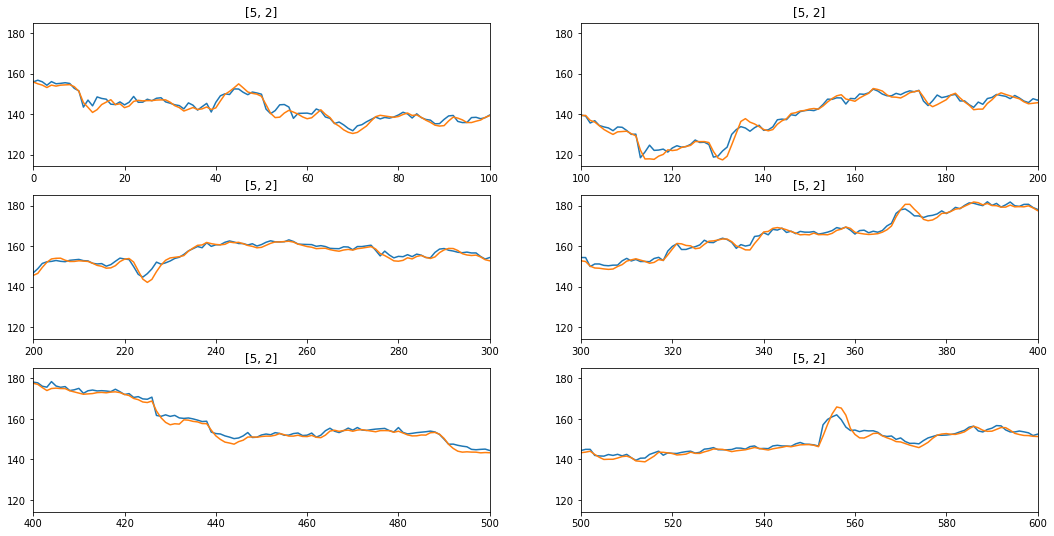

In [41]:

k = 2 # scenario number
plt.figure(figsize = [18,9])
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.title(params[k])
    plt.plot(reverse_test_diff)
    plt.plot(results[k])
    plt.xlim([100*i, 100*(i+1)])

In [42]:
%%time 
import warnings
warnings.filterwarnings('ignore')

history = [x for x in train_diff]

predictions = []
test_output = []

for t in range(len(test_diff)):
    print('Predicting %i of %i'%(t+1, len(test_diff)))
    # START_CODE_HERE - call the ARIMA Method with history and params
    train_set = train_diff.append(test_diff[:t+1])
    # pdq
    model = ARIMA(train_set.values, order = [5, 2, 0]) # initialize the model with history and right order of parameters
    model_fit = model.fit()# fit the model
    # END_CODE_HERE

    output = model_fit.forecast(steps=1)  # use forecast on the fitted model
    
    
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)
    test_output.append(obs)

    if t % 20 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Predicting 1 of 603
Test Series Point: 0	Predicted=-0.895950724237009, Expected=0.8800000000000239
Predicting 2 of 603
Predicting 3 of 603
Predicting 4 of 603
Predicting 5 of 603
Predicting 6 of 603
Predicting 7 of 603
Predicting 8 of 603
Predicting 9 of 603
Predicting 10 of 603
Predicting 11 of 603
Predicting 12 of 603
Predicting 13 of 603
Predicting 14 of 603
Predicting 15 of 603
Predicting 16 of 603
Predicting 17 of 603
Predicting 18 of 603
Predicting 19 of 603
Predicting 20 of 603
Predicting 21 of 603
Test Series Point: 20	Predicted=0.7829991096290949, Expected=1.2900000000000205
Predicting 22 of 603
Predicting 23 of 603
Predicting 24 of 603
Predicting 25 of 603
Predicting 26 of 603
Predicting 27 of 603
Predicting 28 of 603
Predicting 29 of 603
Predicting 30 of 603
Predicting 31 of 603
Predicting 32 of 603
Predicting 33 of 603
Predicting 34 of 603
Predicting 35 of 603
Predicting 36 of 603
Predicting 37 of 603
Predicting 38 of 603
Predicting 39 of 603
Predicting 40 of 603
Predicting

Predicting 319 of 603
Predicting 320 of 603
Predicting 321 of 603
Test Series Point: 320	Predicted=2.750027167640836, Expected=1.2800000000000011
Predicting 322 of 603
Predicting 323 of 603
Predicting 324 of 603
Predicting 325 of 603
Predicting 326 of 603
Predicting 327 of 603
Predicting 328 of 603
Predicting 329 of 603
Predicting 330 of 603
Predicting 331 of 603
Predicting 332 of 603
Predicting 333 of 603
Predicting 334 of 603
Predicting 335 of 603
Predicting 336 of 603
Predicting 337 of 603
Predicting 338 of 603
Predicting 339 of 603
Predicting 340 of 603
Predicting 341 of 603
Test Series Point: 340	Predicted=0.23122260311343945, Expected=-1.039999999999992
Predicting 342 of 603
Predicting 343 of 603
Predicting 344 of 603
Predicting 345 of 603
Predicting 346 of 603
Predicting 347 of 603
Predicting 348 of 603
Predicting 349 of 603
Predicting 350 of 603
Predicting 351 of 603
Predicting 352 of 603
Predicting 353 of 603
Predicting 354 of 603
Predicting 355 of 603
Predicting 356 of 603
Pr

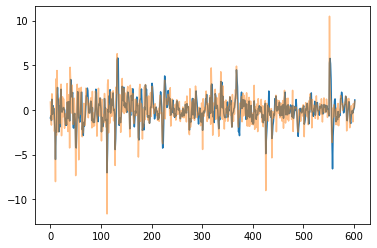

In [43]:
plt.figure()
plt.plot(predictions)
plt.plot(test_output, alpha = 0.5)

### Reverse Transform the forecasted values

This is very important. Since we used differencing of the first order in the series before training, we need to reverse transform the values to get meaningful price forecasts.

In [44]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape


((604,), (604,))

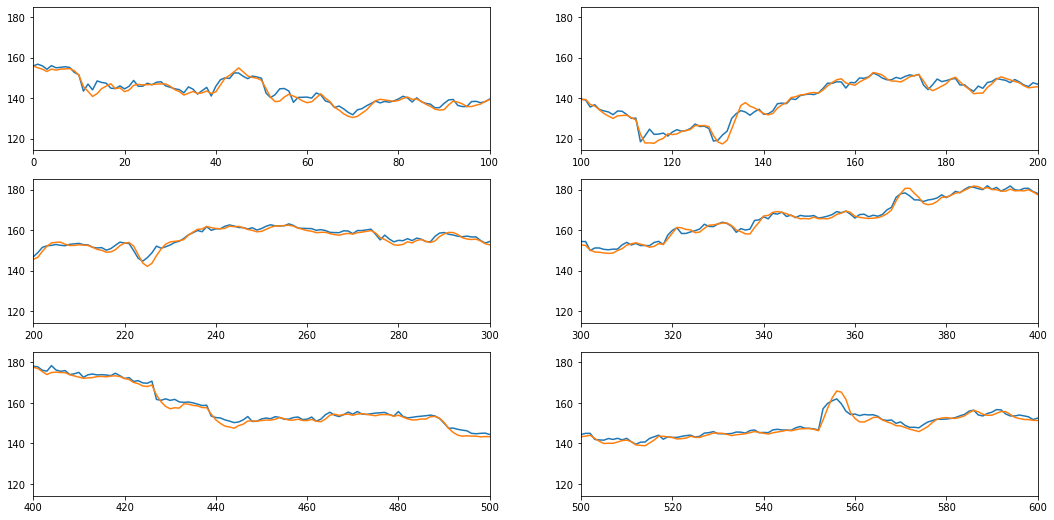

In [45]:
plt.figure(figsize = [18,9])
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.plot(reverse_test_diff)
    plt.plot(reverse_predictions)
    plt.xlim([100*i, 100*(i+1)])

### Evaluate model performance

In [46]:


error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 2.708
Symmetric Mean absolute percentage error: 0.843


The loss results for this model are available above. According to the MSE, the model loss is quite low but for SMAPE is instead consistently higher. One of the main reason for this discrepancy is because SMAPE is commonly used loss a loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed there is still room for improvement of our model.

## Let's Visualize the forecast results

In [47]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index
'''
reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index
'''
reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

In [48]:
print(reverse_test_diff_series)
print(reverse_predictions_series)

Date
2015-08-07    155.89
2015-08-10    156.77
2015-08-11    155.96
2015-08-12    154.26
2015-08-13    156.06
               ...  
2017-12-22    151.82
2017-12-26    152.51
2017-12-27    152.95
2017-12-28    153.20
2017-12-29    154.17
Length: 604, dtype: float64
Date
2015-08-07    155.890000
2015-08-10    154.994049
2015-08-11    154.325669
2015-08-12    153.138796
2015-08-13    154.334136
                 ...    
2017-12-22    151.445892
2017-12-26    151.344989
2017-12-27    151.435401
2017-12-28    151.707046
2017-12-29    152.816431
Length: 604, dtype: float64


### Visualizing train, test and forecast prices

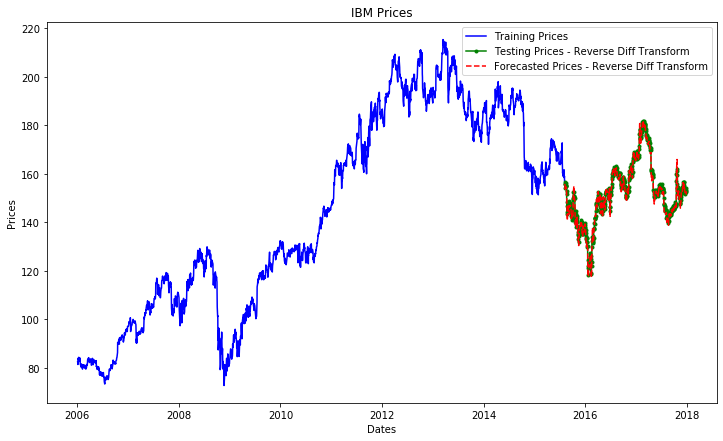

In [49]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();
#plt.xlim([pd.to_datetime('2016-01-01'), pd.to_datetime('2016-02-01')])

### Q10: Visualize only test and forecast prices

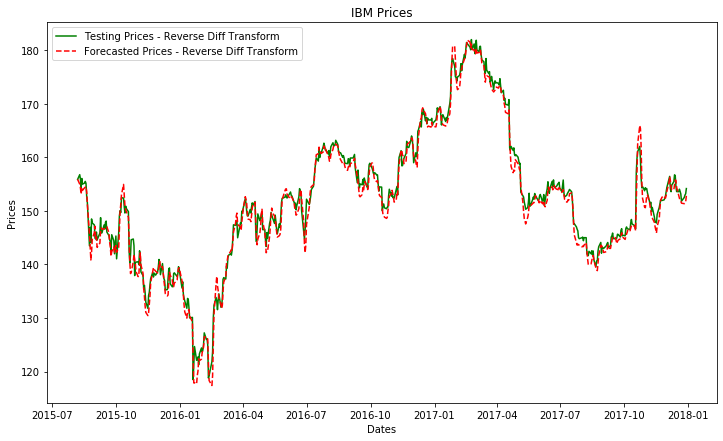

In [52]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

This analysis using ARIMA has performed pretty well in forecasting prices 

# Time Series Forecasting with Deep Learning

The approach uses sequential models, to be more specific - LSTMs, to build a deep learning model that predicts the 'Open' Stock prices of IBM over a period of two years by using data from the previous 10 years.

### LSTM: A brief overview

What are LSTMs? : https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

### Headers

In [54]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

# %tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

### Load Data

In [55]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.we will just examine the "Open" stock prices feature. This same analysis can be repeated for most of the other features.

## Build Train-Test Datasets

In [56]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2415,), (604,))

### Q11: Visualize train and test price data

In [58]:
print(train_series)
print(test_series)

Date
2006-01-03     82.45
2006-01-04     82.20
2006-01-05     81.40
2006-01-06     83.95
2006-01-09     84.10
               ...  
2015-07-31    161.40
2015-08-03    161.70
2015-08-04    158.40
2015-08-05    159.10
2015-08-06    157.13
Name: Open, Length: 2415, dtype: float64
Date
2015-08-07    155.89
2015-08-10    156.77
2015-08-11    155.96
2015-08-12    154.26
2015-08-13    156.06
               ...  
2017-12-22    151.82
2017-12-26    152.51
2017-12-27    152.95
2017-12-28    153.20
2017-12-29    154.17
Name: Open, Length: 604, dtype: float64


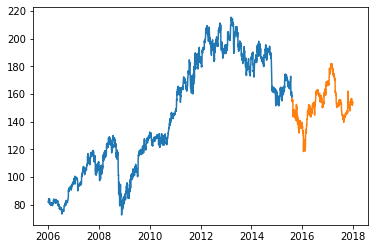

In [60]:
plt.figure()
plt.plot(train_series)
plt.plot(test_series)

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance.

This is done to ensure that the gradient descent is sooner when learning a deep learning model

### Q12: Use the initialized min-max scaler to scale the prices in train_series

In [64]:
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
# END_CODE_HERE

In [65]:
print(training_set_scaled)

[[0.06807347]
 [0.06632081]
 [0.06071228]
 ...
 [0.60053281]
 [0.60544027]
 [0.59162928]]


In [66]:
training_set_scaled.shape

(2415, 1)

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*

Sample image for sliding window:
![Sliding window](imgs/sliding_window.png)

In [67]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2355, 60), (2355,))

#### Reshape X_train

Now we reshape X_train in the format like:

(batch_size, timesteps, input_dim) => (m, features, $x_{i1}$)

The X_train should be now: (2709, 60, 1)

60 features = 60 day sliding window

$x_{i1}$ = 1 data point for each feature and i represents the feature



In [68]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [69]:
X_train.shape

(2355, 60, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

#### Similar Model Architecture (dimensions not exact)

![Similar Model Architecture](imgs/lstm.png)


### Q13: Build the LSTM based forecasting DL Model architecture

Hints:

    - Fill the second LSTM layer using an LSTM cell with 64 units, remember NOT to set return_sequences to True as we are only concerned about passing the last sequence output to the next layer
    - Fill the Output layer with 1 unit
    - Compile the model with mentioned optimizer and loss values

In [73]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1, activation='sigmoid'))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='RMSprop')

regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [75]:
regressor.fit(X_train,y_train, epochs=100, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0101
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0105
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0102
Epoch 4/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 5/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0107
Epoch 7/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 8/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 9/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0088
Epoch 10/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0138
Epoch 11/

34/34 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 83/100
34/34 [==============================] - 0s 10ms/step - loss: 9.8512e-04 - val_loss: 0.0021
Epoch 84/100
34/34 [==============================] - 0s 10ms/step - loss: 9.6089e-04 - val_loss: 0.0020
Epoch 85/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 86/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 4.2269e-04
Epoch 87/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 88/100
34/34 [==============================] - 0s 10ms/step - loss: 9.5816e-04 - val_loss: 0.0029
Epoch 89/100
34/34 [==============================] - 0s 10ms/step - loss: 9.3770e-04 - val_loss: 0.0011
Epoch 90/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 91/100
34/34 [==============================] - 0s 11ms/step - loss: 9.3945e-0

### Test Data Forecasting

#### Data Preparation:
Lets prepare the test data just like we did with the train data.

Remember to start forecasting on the first day of the test data, we need the last 60 days of train data.

Thus, the following steps have been performed so first 60 entires of test set have 60 previous values from the train dataset

### Q14: Get the last 60 records from train_series

In [80]:
train_last60 = test_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


### Q15: Combine both train_last60 and test_series together 

Hint: Check pandas __`concat()`__

In [85]:
new_test_series =  train_last60.append(test_series)
print(new_test_series.shape)
assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(664,)


### Q16: Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

Hint: Don't fit the scaler again here since it has already been trained

In [86]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1,1))

### Prepare Test dataset Windows of 60  days each

In [88]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(604, 60, 1)

### Model Prediction and Reverse Transform of Prices

In [89]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

((604,), (604,))

## Model Evaluation

In [90]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 38.324
Symmetric Mean absolute percentage error: 3.474


## Visualizing the results from model predictions

### Visualize train, test and forecasted prices

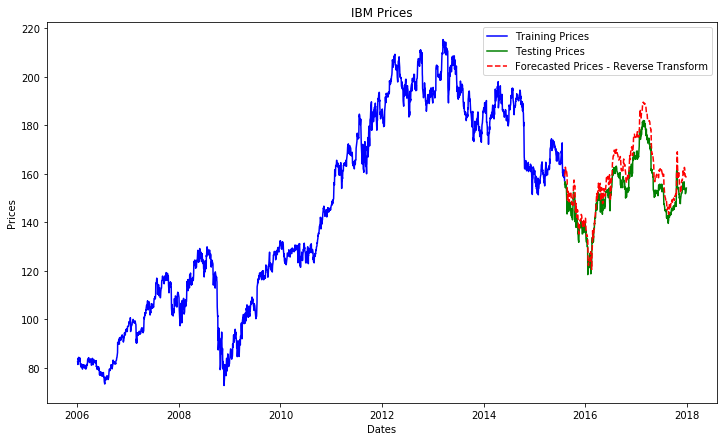

In [91]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

### Q17: Visualize only test and forecast prices

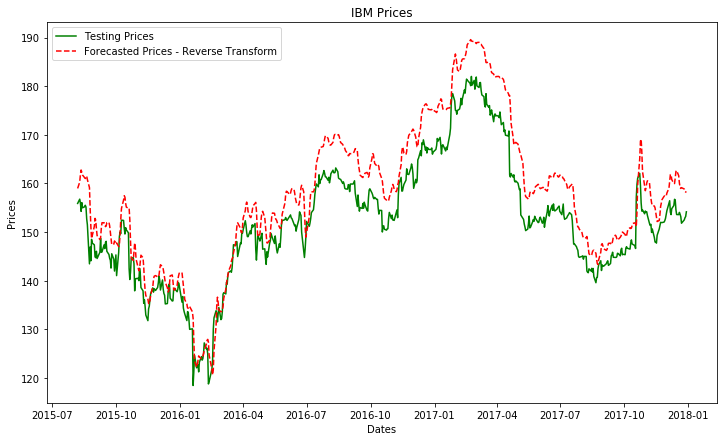

In [92]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

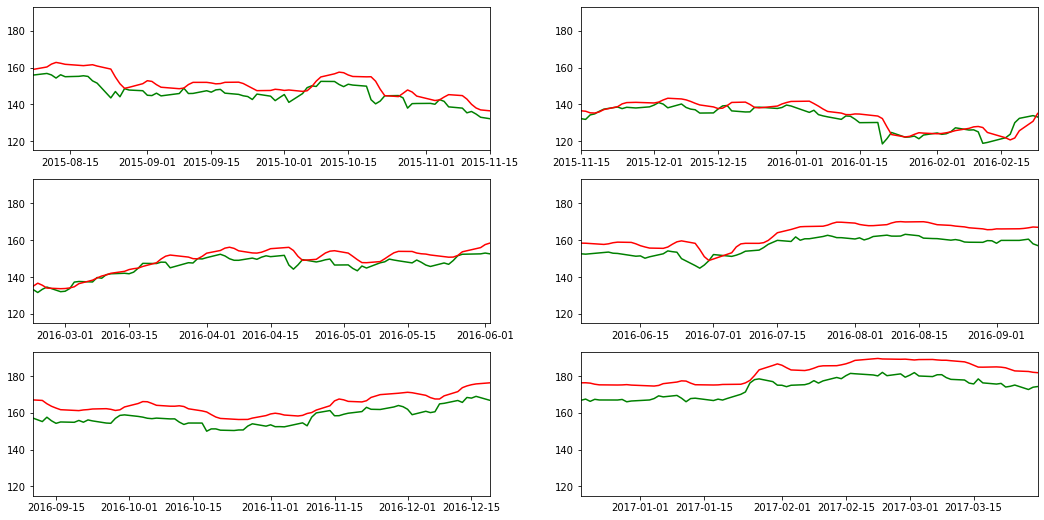

In [101]:
plt.figure(figsize = [18,9])
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.plot(test_series, color='green')
    plt.plot(predicted_stock_price_revtrans_series, color='red')
    plt.xlim(np.array([test_series.index[0]+np.timedelta64(100*i,'D'), test_series.index[0]+np.timedelta64(100*i+100,'D')]))

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.